In [1]:
import vtk
import matplotlib.pyplot as plt
import numpy as np
import os
from vtk import vtkUnstructuredGridReader
from vtk import vtkXMLUnstructuredGridReader
from vtk.util import numpy_support as VN
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial import KDTree
from scipy.interpolate import RegularGridInterpolator
from scipy.signal import savgol_filter
import pygmt
import parallel_curves

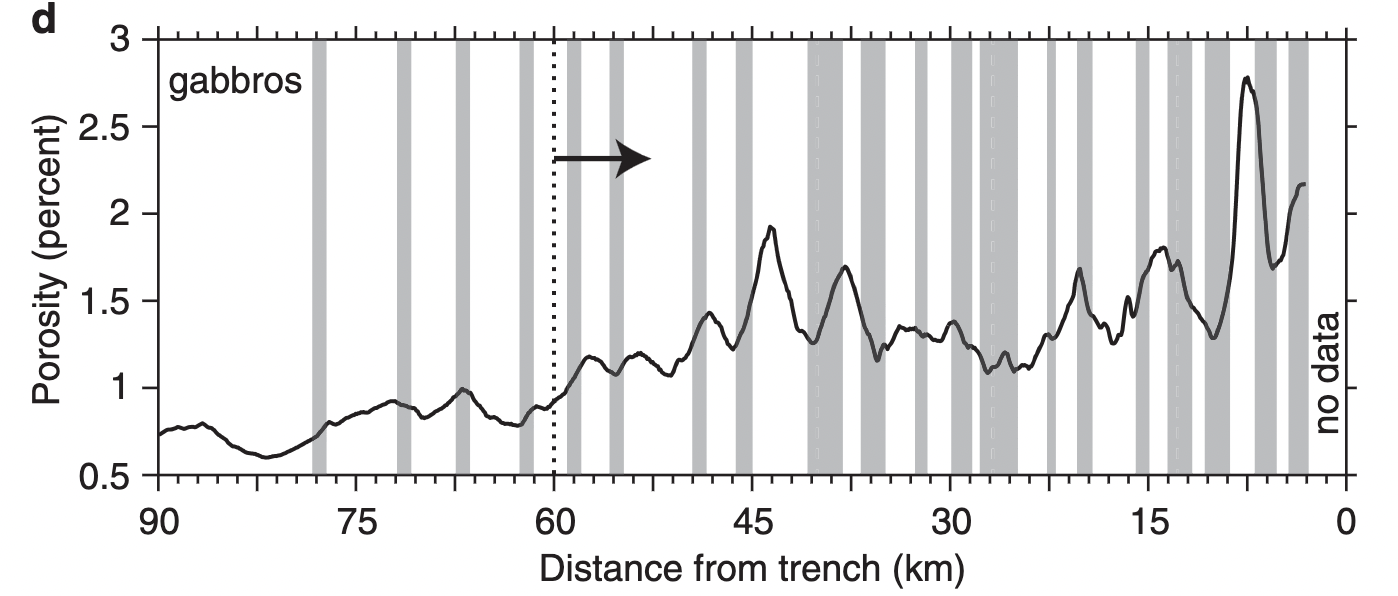

# Load in the Bathymetry Profile

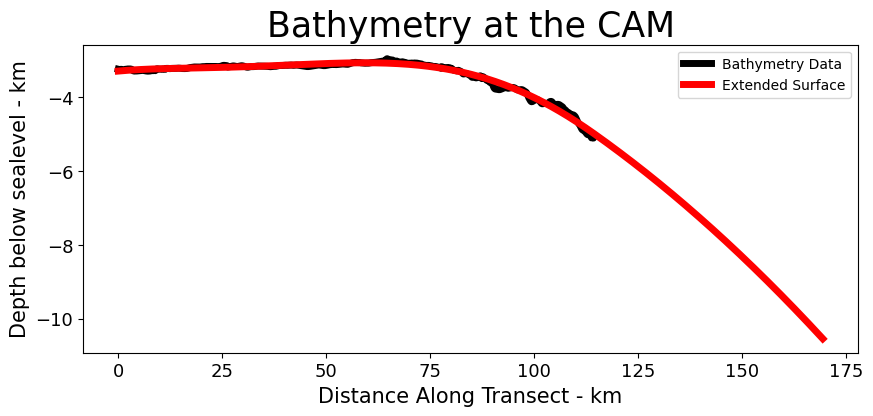

In [2]:
save_dir = "/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/TEXT_FILES_FOR_DB_CONVERSION/"

trench_name = 'CAM'
geomap_file = 'Bathymetry_Lines/' + trench_name + '_Line.txt'
data = np.loadtxt(fname=geomap_file, skiprows=2)
x = data[:, 2] * 1e3
w = data[:, 3]

outer_rise_faults = np.max(x) - np.array([5, 7, 9.5, 12.5, 15, 19.5, 22, 25.5, 27, 29, 32, 36, 39, 41.5, \
                                          46, 49, 55.5, 58.5, 62, 67, 71, 78]) * 1e3

poly_coeffs = np.polyfit(x, w, deg=5)
smooth_surface = np.zeros(len(x))
for p in range(len(poly_coeffs)):
    smooth_surface += poly_coeffs[p] * x**(len(poly_coeffs) - 1 - p)

x_extended = np.linspace(0, 170e3, 10000)
surface_extended = np.zeros(len(x_extended))
first_deriv = np.gradient(smooth_surface, x)
second_deriv = np.gradient(first_deriv, x)
y_val = smooth_surface[-1]
x_val = x[-1]
a_val = second_deriv[-1] / 2
b_val = first_deriv[-1] - 2 * a_val * x_val
c_val = y_val - a_val * x_val**2 - b_val * x_val
extend_values_x = np.linspace(x[-1], x[-1] + 55e3, 600)
extend_values_w = a_val * extend_values_x**2 + b_val * extend_values_x + c_val

x_extended = np.concatenate( (x, extend_values_x) )
surface_extended = np.concatenate( (smooth_surface, extend_values_w) )
    
minimum_bath_index = np.where(smooth_surface == np.max(smooth_surface))
reference_surface = smooth_surface[minimum_bath_index]

plt.figure(dpi=100, figsize=(10, 4))
plt.plot(x/1e3 , w/1e3, c='k', label='Bathymetry Data', lw=5)
# plt.plot(x/1e3, smooth_surface/1e3, c='r', label='Model Surface', lw=5)
plt.plot(x_extended/1e3, surface_extended/1e3, lw=5, c='red', label="Extended Surface")
plt.xlabel('Distance Along Transect - km', fontsize=15)
plt.ylabel('Depth below sealevel - km', fontsize=15)
plt.title('Bathymetry at the ' + trench_name, fontsize=25)
plt.tick_params(labelsize=13)
plt.legend()
plt.savefig("Figures/bath_with_model_extended.png", bbox_inches="tight")
plt.show()


# Load in the Slab2.0 Profile

In [3]:
1 - 60/72

0.16666666666666663

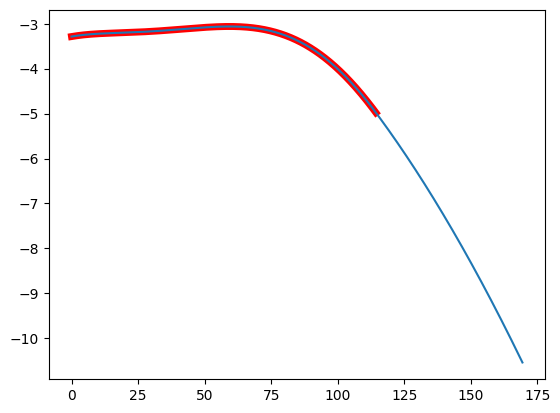

In [4]:
first_deriv = np.gradient(smooth_surface, x)
second_deriv = np.gradient(first_deriv, x)
y_val = smooth_surface[-1]
x_val = x[-1]
a_val = second_deriv[-1] / 2
b_val = first_deriv[-1] - 2 * a_val * x_val
c_val = y_val - a_val * x_val**2 - b_val * x_val
extend_values_x = np.linspace(x[-1], x[-1] + 55e3, 600)
extend_values_w = a_val * extend_values_x**2 + b_val * extend_values_x + c_val

x_extended = np.concatenate( (x, extend_values_x) )
surface_extended = np.concatenate( (smooth_surface, extend_values_w) )

plt.plot(x/1e3, smooth_surface/1e3, c='r', label='Model Surface', lw=5)
plt.plot(x_extended/1e3, surface_extended/1e3)

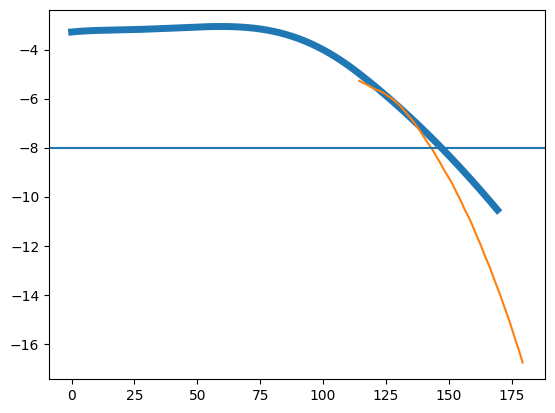

In [5]:
slab2_x = np.loadtxt(fname="slab_top_profile.txt", usecols=0) * 0
slab2_y = np.loadtxt(fname="slab_top_profile.txt", usecols=2) * 1e3 - reference_surface

for i in range(len(slab2_x)):
    slab2_x[i] = i * 1e3

# plt.plot(x/1e3, smooth_surface/1e3, c='r', label='Model Surface')
test_inds = np.where(slab2_y >= -15e3)
plt.plot(x_extended/1e3, surface_extended/1e3,lw=5)
plt.plot(slab2_x[test_inds]/1e3 + np.max(x/1e3), slab2_y[test_inds]/1e3 + np.min(smooth_surface/1e3) - reference_surface/1e3)
plt.axhline(-8)

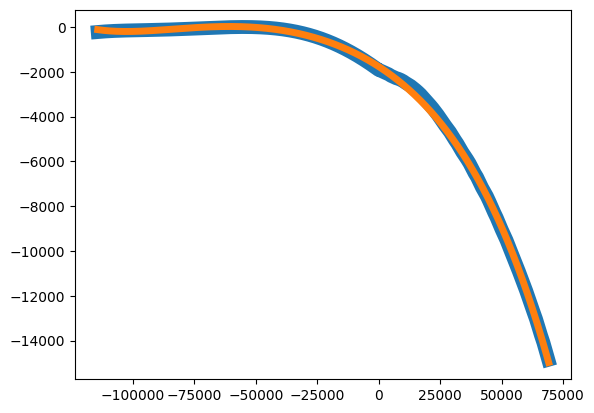

In [6]:
slab2_x = np.loadtxt(fname="slab_top_profile.txt", usecols=0) * 0
slab2_y = np.loadtxt(fname="slab_top_profile.txt", usecols=2) * 1e3 - reference_surface

bath_x  = x - np.max(x)
bath_y  = smooth_surface - reference_surface

bath_x = np.delete(bath_x, -1)
bath_y = np.delete(bath_y, -1)

shift_slab2_y = np.min(bath_y) - np.max(slab2_y)
slab2_y += shift_slab2_y
for i in range(len(slab2_x)):
    slab2_x[i] = i * 1e3

combined_x = np.concatenate( (bath_x, slab2_x) )
combined_y = np.concatenate( (bath_y, slab2_y) )

# cutoff_depth = -5e3
cutoff_depth = -15e3
cutoff_indices = np.where( combined_y >= cutoff_depth )
shallow_x = combined_x[cutoff_indices]
shallow_y = combined_y[cutoff_indices]

poly_coeffs = np.polyfit(shallow_x, shallow_y, deg=5)

dx = 100
smooth_shallow_x = np.arange(np.min(shallow_x), np.max(shallow_x) + 2*dx, dx)
smooth_shallow_y = np.zeros(len(smooth_shallow_x))
for p in range(len(poly_coeffs)):
    smooth_shallow_y += poly_coeffs[p] * smooth_shallow_x**(len(poly_coeffs) - 1 - p)

    
plt.plot(combined_x[cutoff_indices], combined_y[cutoff_indices], lw=10)
plt.plot(smooth_shallow_x, smooth_shallow_y, lw=5)
plt.show()

In [7]:
g = 9.81
water_density = 1030
crustal_density = 2700
trench_inds = np.where(smooth_shallow_x > 0)
pressure_profile = (smooth_shallow_y + reference_surface) * -g * water_density
pressure_profile[trench_inds] = (smooth_shallow_y[trench_inds] + reference_surface) * -g * crustal_density * (smooth_shallow_x[trench_inds] / np.max(smooth_shallow_x))
pressure_profile[trench_inds] += (smooth_shallow_y[trench_inds] + reference_surface) * -g * water_density * ( (np.max(smooth_shallow_x) - smooth_shallow_x[trench_inds]) / np.max(smooth_shallow_x))

# fluid_pressure_into_text_file = np.array([smooth_shallow_x[trench_inds], \
#                                          (smooth_shallow_y[trench_inds] + reference_surface) * -g * water_density]).T
fluid_pressure_into_text_file = np.array([smooth_shallow_x, \
                                          pressure_profile]).T
np.savetxt(fname=save_dir + trench_name + '_fluid_pressure.txt', X=fluid_pressure_into_text_file)


gmtset [ERROR]: Pen name None not recognized!
gmtset [WARNING]: Representation of pen width (None) not recognized. Using default.


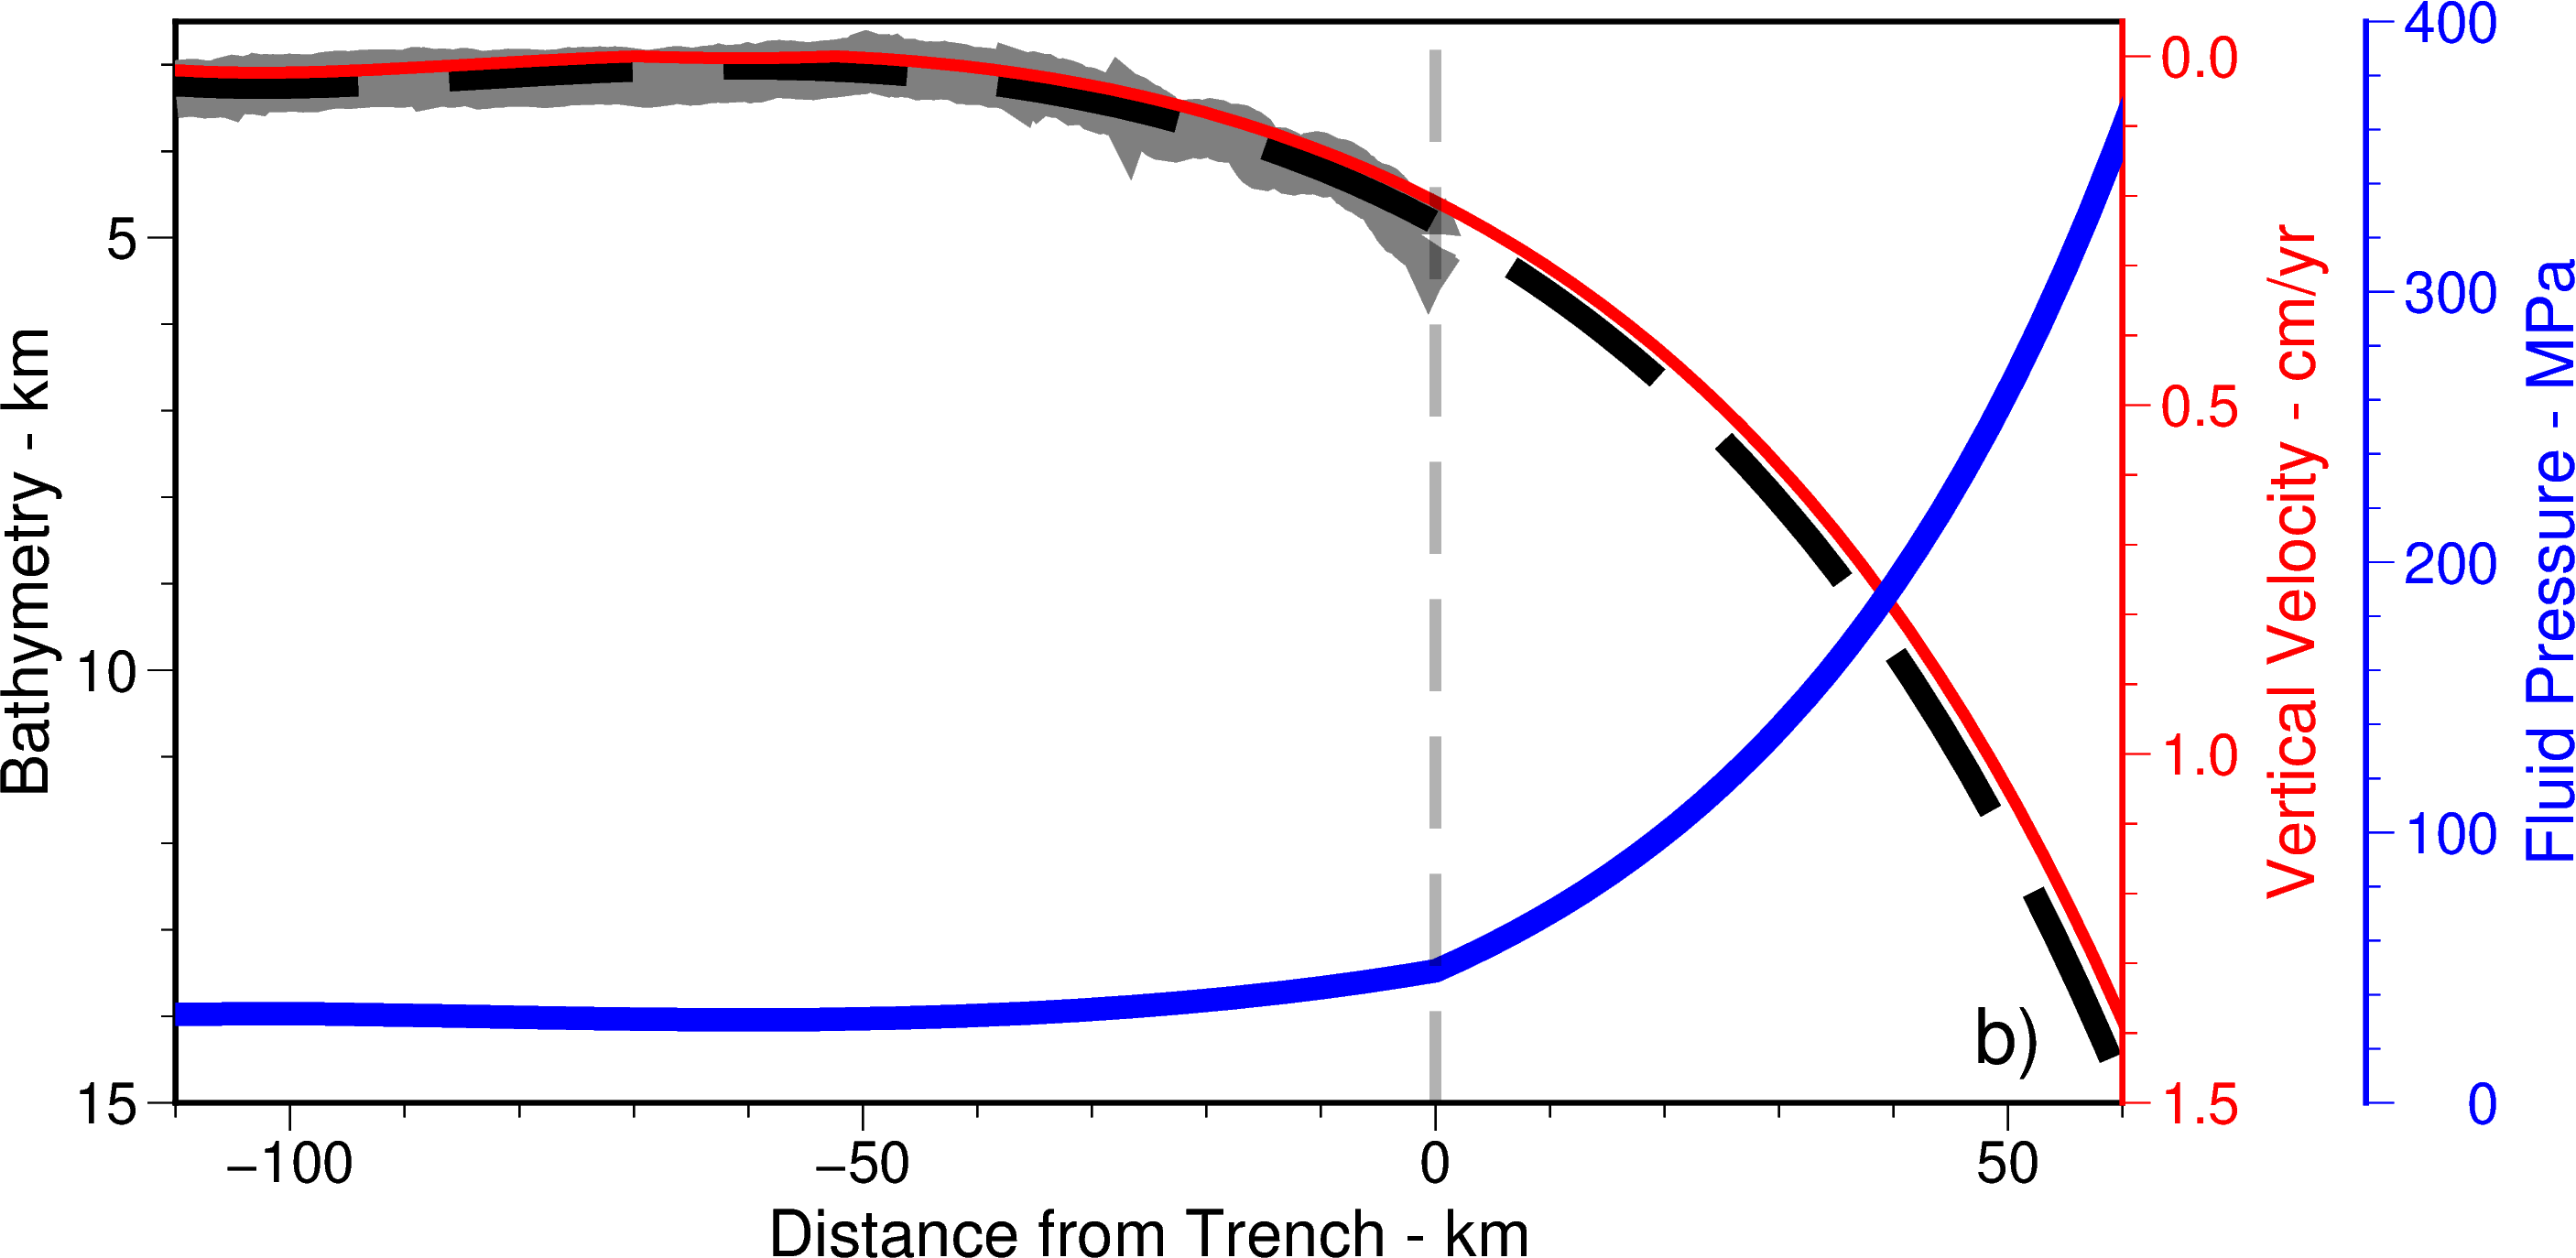

In [70]:
import numpy as np
import pygmt

fig = pygmt.Figure()
pygmt.config(FONT_LABEL='17p', MAP_LABEL_OFFSET='0.25', MAP_TICK_PEN_PRIMARY=None, FONT_ANNOT_PRIMARY='15p',
             MAP_TICK_LENGTH_PRIMARY=0.25)
# Plot the common X axes
# The bottom axis (S) is plotted with annotations and tick marks
# The top axis (t) is plotted without annotations and tick marks
# The left and right axes are not drawn
fig.basemap(region=[-110, 60, 2.5, 15], projection="X18c/-10c", frame=["St", "xaf+lDistance from Trench - km"])

# Plot the Y axis for y1 data
# The left axis (W) is plotted with blue annotations, ticks, and label
with pygmt.config(
    MAP_FRAME_PEN="black",
    MAP_TICK_PEN="black",
    FONT_ANNOT_PRIMARY="black",
    FONT_LABEL="black",
):
    fig.basemap(frame=["W", "yaf+lBathymetry - km"])

# Plot the line for y1 data
# fig.plot(x=(x - np.max(x))/1e3 , y=abs(w)/1e3, style="c0.5c", pen="0p,black", fill="gray50")
    fig.plot(x=(x - np.max(x))/1e3 , y=abs(w)/1e3, pen="15p,gray50")
# Plot points for y1 data
fig.plot(x=smooth_shallow_x/1e3, y=abs(smooth_shallow_y + reference_surface) / 1e3, pen="6p,black,--")

# Plot the Y axis for y2 data
# The right axis (E) is plotted with red annotations, ticks, and label
with pygmt.config(
    MAP_FRAME_PEN="red",
    MAP_TICK_PEN="red",
    FONT_ANNOT_PRIMARY="red",
    FONT_LABEL="red",
):
    fig.basemap(region=[-110, 60, -0.05, 1.5], projection="X18c/-10c", frame=["E", "yaf+lVertical Velocity - cm/yr"])
    
fig.plot(x=smooth_shallow_x/1e3, y=abs(smooth_shallow_y) / 850e3 * 100, pen="3p,red")


fig.shift_origin(xshift=2.25, yshift=0)
with pygmt.config(
    MAP_FRAME_PEN="blue",
    MAP_TICK_PEN="blue",
    FONT_ANNOT_PRIMARY="blue",
    FONT_LABEL="blue",
):
    fig.basemap(region=[-110, 60, 0, 400], projection="X18c/10c", frame=["E", "yaf+lFluid Pressure - MPa"])
fig.shift_origin(xshift=-2.25, yshift=0)

fig.plot(x=smooth_shallow_x/1e3, y=fluid_pressure_into_text_file[:, 1] / 1e6, pen="6p,blue")

fig.plot(x=np.array([0, 0]), y=np.array([-1000, 1000]), pen="3p,black,--", transparency=70)

fig.text(x=50, y=25, text="b)", font="20p")

fig.savefig(fname="Figures/bath_fluid_pressure.png")

fig.show()

In [ ]:
line_thickness = "10p"
fig = pygmt.Figure()
pygmt.config(FONT_LABEL='17p', MAP_LABEL_OFFSET='0.5', MAP_TICK_PEN_PRIMARY=None, FONT_ANNOT_PRIMARY='15p')
region = [-23.5, -12.5, -0.1, 10]
fig.basemap(region=region, projection="X15c/-10c", frame=["WSne", "xa2f1+llog(Permeability) - m@+2@+", "ya1+lDepth Below Basement - km"])


In [383]:
figure_size_x = 10
figure_size_y = 7

main_panel  = [0, figure_size_y, figure_size_x, figure_size_y]

fig = plt.figure(dpi=100, figsize=(figure_size_x, figure_size_y))
ax1 = plt.axes(main_panel)

########################################### TOP PANEL ##########################################
ax1.set_xlabel('Distance From Trench - km', fontsize=250, labelpad=50, fontname="Arial")
ax1.set_ylabel('Depth to Basement - km', color="black", fontsize=250, fontname="Arial")
ax1.plot((x - np.max(x))/1e3 , abs(w)/1e3, c='gray', lw=150, label="Observed Bathymetry")
ax1.plot(smooth_shallow_x/1e3, abs(smooth_shallow_y + reference_surface) / 1e3, color="black", 
         lw=100, label="Model Bathymetry", ls='--')
ax1.tick_params(axis='y', labelcolor="black", labelsize=200, length=100, width=20, right=True)
ax1.tick_params(axis='x', labelcolor='k', labelsize=200, length=100, width=20, top=True, labeltop=True, direction="inout")
ax1.axvline(0, c='k', ls='--', lw=20, alpha=0.5)
ax1.set_yticks([2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0])
ax1.invert_yaxis()

ax1.xaxis.set_label_position('bottom') 

ax2 = ax1.twinx()

######################################### BOTTOM PANEL #########################################
color = 'tab:red'
ax2.set_xlabel('Distance From Trench - km', fontsize=250, fontname="Arial")
ax2.set_ylabel('Vertical Velocity - cm/yr', color=color, fontsize=250, fontname="Arial")
ax2.plot(smooth_shallow_x/1e3, abs(smooth_shallow_y) / 850e3 * 100, color="red", lw=40)
ax2.tick_params(axis='y', labelcolor=color, labelsize=200, length=100, width=20)
ax2.tick_params(axis='x', labelcolor='k', labelsize=200, length=100, width=20, top=True, direction="inout")
ax2.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
ax2.invert_yaxis()

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
y3 = [i**0.5 for i in x]
ax3.spines['right'].set_position(('axes', 1.125))  # Move third y-axis outwards

color = 'tab:blue'
ax3.set_ylabel('Fluid Pressure - MPa', color=color, fontsize=250, fontname="Arial")
ax3.plot(smooth_shallow_x/1e3, fluid_pressure_into_text_file[:, 1] / 1e6, color=color, lw=40)
ax3.tick_params(axis='y', labelcolor=color, labelsize=200, length=100, width=20)
ax3.set_yticks([0, 100, 200, 300, 400, 500])
ax1.axvline(0, c='k', ls='--', lw=20, alpha=0.5)

ax1.text(-120, 6.0, "b)", fontsize=300, fontname="Arial")

for spine in ax1.spines.values():
    spine.set_linewidth(5)

for spine in ax2.spines.values():
    spine.set_linewidth(5)
    
for spine in ax3.spines.values():
    spine.set_linewidth(5)

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig("Figures/bath_fluid_pressure.png", bbox_inches="tight")
plt.show()

/var/folders/zw/0t9y_fkn22l4df48w2pgzd280000gn/T/ipykernel_32535/925462434.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout() # otherwise the right y-label is slightly clipped


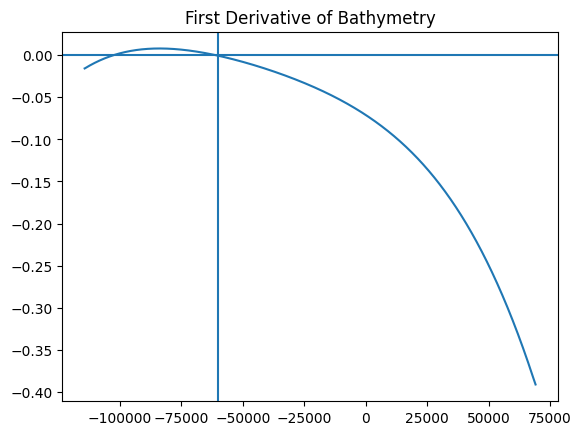

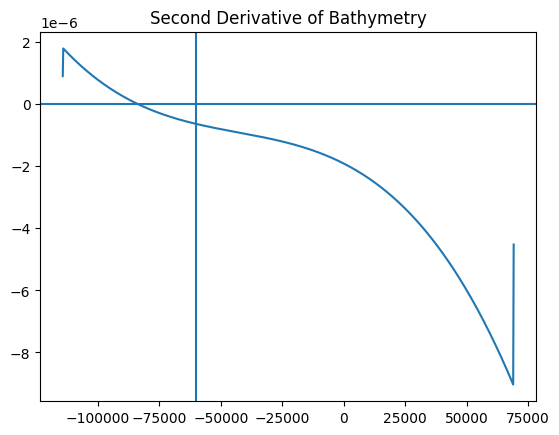

In [226]:
first_deriv = np.gradient(smooth_shallow_y, smooth_shallow_x)
second_deriv = np.gradient(first_deriv, smooth_shallow_x)
plt.title('First Derivative of Bathymetry')
plt.plot(smooth_shallow_x, first_deriv)
plt.axhline(0)
plt.axvline(-60e3)
plt.show()

plt.title('Second Derivative of Bathymetry')
plt.plot(smooth_shallow_x, second_deriv)
plt.axhline(0)
plt.axvline(-60e3)
# plt.ylim(-5e-6, 5e-6)
plt.show()

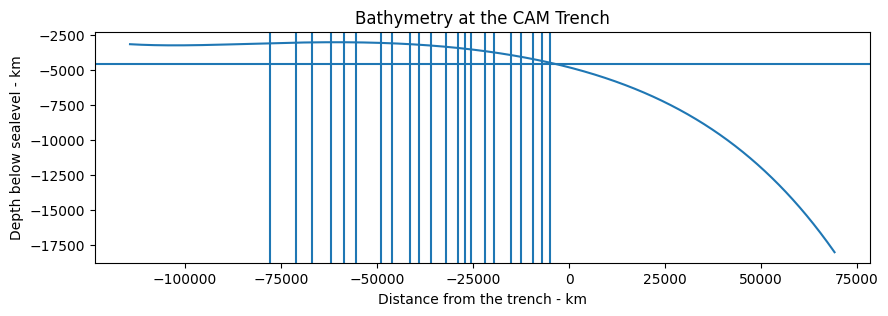

In [224]:
plt.figure(dpi=100, figsize=(10, 3))

outer_rise_faults = -np.array([5, 7, 9.5, 12.5, 15, 19.5, 22, 25.5, 27, 29, 32, 36, 39, 41.5, \
                               46, 49, 55.5, 58.5, 62, 67, 71, 78]) * 1e3

plt.plot(smooth_shallow_x, smooth_shallow_y + reference_surface)
plt.xlabel('Distance from the trench - km')
plt.ylabel('Depth below sealevel - km')
plt.title('Bathymetry at the ' + trench_name + ' Trench')
for val in outer_rise_faults:
    plt.axvline(val)

# plt.ylim(-8000, -2000)
# plt.xlim(-120e3, 50e3)
plt.axhline(-4600)
plt.show()

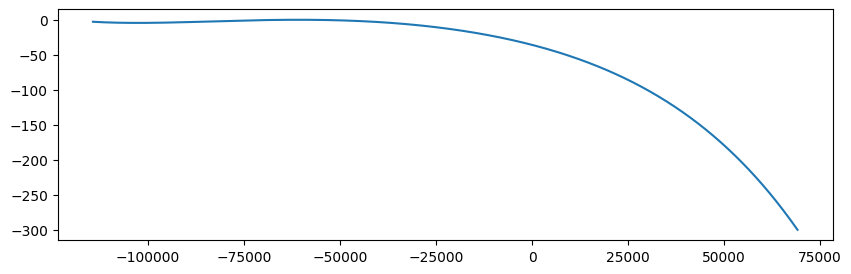

In [231]:
plt.figure(dpi=100, figsize=(10, 3))
# time_duration = 850e3
time_duration = 50
test_velocity = (smooth_shallow_y) / time_duration

plt.plot(smooth_shallow_x, test_velocity)
into_textfile = np.array([smooth_shallow_x, test_velocity]).T
np.savetxt(fname=save_dir + trench_name + '_velocity_' + str(int(time_duration)) + '.txt', \
           X=into_textfile)

# Write out the elastic stress due to bending at the right most boundary

In [151]:
# E and nu come from Turcotte and Schubert for Basalt
right_boundary_x = 20e3
shear_modulus    = 50e9
bulk_modulus     = 80e9
Poissons_ratio   = (3*bulk_modulus - 2*shear_modulus) / (6*bulk_modulus - 2*shear_modulus)
Youngs_Modulus   = 3*bulk_modulus * (1 - 2*Poissons_ratio)
beam_thickness   = 30e3

y_vals = np.linspace(-beam_thickness/2, beam_thickness/2, 3000)
second_deriv_at_right_boundary = second_deriv[abs(smooth_shallow_x - right_boundary_x).argmin()]

sigma_xx = -y_vals * Youngs_Modulus / (1 - Poissons_ratio**2) * second_deriv_at_right_boundary

into_textfile = np.array([y_vals - np.max(y_vals), sigma_xx]).T
np.savetxt(fname=save_dir + trench_name + '_right_boundary_pressure.txt', X=into_textfile)

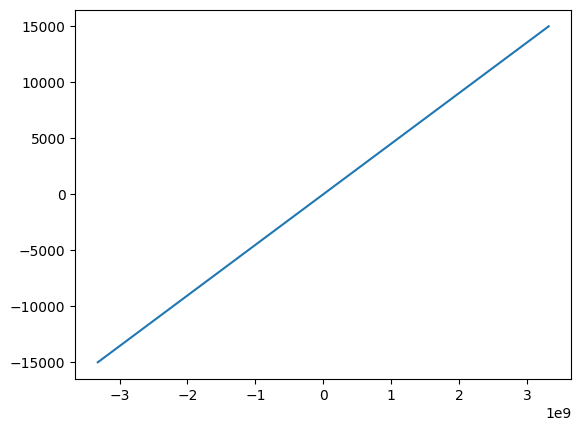

In [152]:
plt.plot(sigma_xx, y_vals)